In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

torch.__version__

'1.13.0+cu116'

In [ ]:
class model(nn.Module):
    def __init__(self, input_dim=22, output_dim=1, num_hidden_layers=20, hidden_dim=100):
        super().__init__()
        
        self.hidden_layers = nn.ModuleList()
        self.dropout = nn.Dropout(p=0.2)

        for i in range(num_hidden_layers):
            self.hidden_layers.append(nn.Linear(input_dim if i == 0 else hidden_dim, hidden_dim))

        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        for idx, layer in enumerate(self.hidden_layers):
            if (idx+1 % 5):
                x = self.dropout(x)
            x = torch.relu(layer(x))
        return self.output_layer(x)

In [ ]:
def func1(x:list):
    w = [1, 1, 2, 2, 2, 4, 4, 5, 5, 8, 9, 10, 11, 11, 10, 7, 5, 3, 3, 2, 2, 1]
    ans = 0
    for i in range(len(w)):
        ans += w[i]*x[i]/sum(w)
    return ans

def func2(x:list):
    ans = 0
    for i in x:
        ans += pow(0.91, 0.04*max(0,i-750)) * pow(0.87, 0.01*max(0,750-i)) / len(x)
    return ans

def func3(x:list):
    ans = 0
    for i in x:
        ans += pow(0.91, 0.07*max(0,i-200)) * pow(0.93, 0.01*max(0,200-i)) / len(x)
    return ans

def PredictH(x:list):
    ans = (func3(x[0:8])+func3(x[10:20]))*func2(x[9:17])*func1(x)
    return ans

In [ ]:
class data_set(Dataset):
    def __init__(self, data, label):
        data = torch.tensor(data).float()
        data = F.normalize(data)
        self.data = data
        self.label = label
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return torch.tensor(self.data[index]).float(), torch.tensor(self.label[index]).float()

In [ ]:
def generate_data(dtran, size):
    a, b, c, d, e, f = int(dtran[0]), int(dtran[1]), int(dtran[2]), int(dtran[3]), int(dtran[4]), int(dtran[5])
    DATA = [[np.random.randint(a, b) for i in range(7)] + [np.random.randint(c, d) for i in range(8)] + [np.random.randint(e, f) for i in range(7)] for i in range(size)]
    for i in range(len(DATA)):
        for j in range(i+1, len(DATA)):
            if (DATA[i] == DATA[j]):
                DATA[j] = [0 for k in range(22)]
    LABEL = []
    for data in DATA:
        LABEL.append([PredictH(data)])
    return DATA, LABEL

In [ ]:
import json
def fetch_data():
    PATH = ""
    with open(PATH, "r", encoding = "utf-8") as r:
        jdata = json.load(r)

    DATA = []
    LABEL = []
    for value in jdata["data"]:
        DATA.append(value[0])
        LABEL.append(value[1])   
    return DATA, LABEL

10000
2000


<ipython-input-29-255e1971e204>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.data[index]).float(), torch.tensor(self.label[index]).float()


<Epoch 1> training loss: 19586.5752
<Epoch 1> validation loss: 4851.0678
<Epoch 2> training loss: 5122.047
<Epoch 2> validation loss: 2202.9741
<Epoch 3> training loss: 4240.279
<Epoch 3> validation loss: 2148.4988
<Epoch 4> training loss: 3914.2704
<Epoch 4> validation loss: 2281.2791
<Epoch 5> training loss: 3587.7332
<Epoch 5> validation loss: 2457.0051
<Epoch 6> training loss: 3488.6503
<Epoch 6> validation loss: 2462.1047
<Epoch 7> training loss: 3387.3513
<Epoch 7> validation loss: 2075.1522
<Epoch 8> training loss: 3174.1222
<Epoch 8> validation loss: 2111.5049
<Epoch 9> training loss: 3131.8753
<Epoch 9> validation loss: 2095.0149
<Epoch 10> training loss: 3092.229
<Epoch 10> validation loss: 2188.3608
<Epoch 11> training loss: 2984.1062
<Epoch 11> validation loss: 2198.63
<Epoch 12> training loss: 2944.9408
<Epoch 12> validation loss: 2068.8711
<Epoch 13> training loss: 2945.305
<Epoch 13> validation loss: 2071.9619
<Epoch 14> training loss: 2904.1808
<Epoch 14> validation los

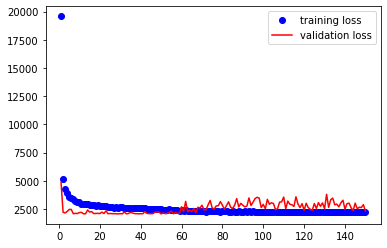

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

batch_size = 24
n_epoch = 150

DATA, LABEL = generate_data([0, 400, 250, 1500, 0, 500], 10000)
print(len(DATA))
datasplit = int(len(DATA)/5)
DATA1, LABEL1 = DATA[datasplit:], LABEL[datasplit:]
DATA2, LABEL2 = DATA[:datasplit], LABEL[:datasplit]

print(len(DATA2))

train_dataset = data_set(DATA1, LABEL1)
test_dataset = data_set(DATA2, LABEL2)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

model = model()
model.to(device)
learning_rate = 0.001
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

def fit(epoch, model, dataloader, training = True):
    if training: 
        model.train() 
    else: 
        model.eval()

    mode = "training" if training else "validation"
    running_loss = 0.0

    cnt = 0
    for index, (data, target) in enumerate(dataloader):
        cnt += 1
        data, target = data.to(device), target.to(device)

        output = model(data)
        loss = criterion(output, target)

        running_loss += loss.item()

        if (training):
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    #loss = running_loss / len(dataloader.dataset)
    loss = running_loss / cnt
    print(f'<Epoch {epoch}> {mode} loss: {round(loss, 4)}')
    return loss

#training
train_losses, val_losses = [], []

for epoch in range(1, n_epoch+1):
    epoch_train_loss = fit(epoch, model, train_dataloader, True)
    train_losses.append(epoch_train_loss)
    epoch_val_loss = fit(epoch, model, test_dataloader, False)
    val_losses.append(epoch_val_loss)

torch.save(model.state_dict(), './model.ckpt')
print("Model saved")

#visualize
plt.plot(range(1, len(train_losses)+1), train_losses, 'bo', label = 'training loss')
plt.plot(range(1, len(val_losses)+1), val_losses, 'r', label = 'validation loss')
plt.legend()

In [ ]:
"""
model = model()
model.load_state_dict(torch.load('./model.ckpt'))

epochs = 1
criterion = nn.MSELoss()

DATA1, LABEL1 = generate_data(100)

test_dataset = data_set(DATA1, LABEL1)

test_dataloader = DataLoader(test_dataset, batch_size=10, shuffle=True)

average_loss = 0
predicts = []
labels = []
for epoch in range(epochs):
    total_loss = 0
    with torch.no_grad():
        for idx, (batch_x, batch_y) in enumerate(test_dataloader):
            pred_y = model(batch_x)
            predicts.append(pred_y[0])
            labels.append(batch_y[0])
            loss = criterion(pred_y, batch_y)
            print(f"{idx+1}  y:{batch_y[0]}  pred_y:{pred_y[0]}  loss: {criterion(batch_y[0], pred_y[0])}")
            
            total_loss += float(loss) / len(test_dataloader)
        average_loss += total_loss/epochs

print(f"Average Loss: {average_loss}")
plt.title("Model Test")
plt.scatter([i for i in range(1, len(predicts)+1)], predicts, color ='red')
plt.scatter([i for i in range(1, len(labels)+1)], labels, color ='blue')
plt.ylabel("Value")
plt.xlabel("n th data")
plt.grid(True)
plt.show()"""

'\nmodel = model()\nmodel.load_state_dict(torch.load(\'./model.ckpt\'))\n\nepochs = 1\ncriterion = nn.MSELoss()\n\nDATA1, LABEL1 = generate_data(100)\n\ntest_dataset = data_set(DATA1, LABEL1)\n\ntest_dataloader = DataLoader(test_dataset, batch_size=10, shuffle=True)\n\naverage_loss = 0\npredicts = []\nlabels = []\nfor epoch in range(epochs):\n    total_loss = 0\n    with torch.no_grad():\n        for idx, (batch_x, batch_y) in enumerate(test_dataloader):\n            pred_y = model(batch_x)\n            predicts.append(pred_y[0])\n            labels.append(batch_y[0])\n            loss = criterion(pred_y, batch_y)\n            print(f"{idx+1}  y:{batch_y[0]}  pred_y:{pred_y[0]}  loss: {criterion(batch_y[0], pred_y[0])}")\n            \n            total_loss += float(loss) / len(test_dataloader)\n        average_loss += total_loss/epochs\n\nprint(f"Average Loss: {average_loss}")\nplt.title("Model Test")\nplt.scatter([i for i in range(1, len(predicts)+1)], predicts, color =\'red\')\nplt